In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
importlib.reload(kgs);
import batman

local
local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 462 ms, sys: 74.6 ms, total: 537 ms
Wall time: 1.69 s


(1100, 1)

In [1]:
%%time
import ariel_load
import copy
kgs.profiling=False
importlib.reload(ariel_load)
loaders = ariel_load.default_loaders()
loaders[1].apply_time_binning.time_binning *= 3
for ii in range(1):
    d = copy.deepcopy(train_data[ii])
    d.transits[0].load_to_step(5, d, loaders)
    print(d.transits[0].data[0].data.shape, d.transits[0].data[1].data.shape)
    plt.figure()
    plt.plot(d.transits[0].data[0].times.get(),d.transits[0].data[0].data.get()/np.mean(d.transits[0].data[0].data.get()))
    #plt.plot(d.transits[0].data[1].times.get(),np.mean(d.transits[0].data[1].data[:,:141].get(),1)/np.mean(d.transits[0].data[1].data[:,:141].get()))
    #plt.plot(d.transits[0].data[1].times.get(),np.mean(d.transits[0].data[1].data[:,141:].get(),1)/np.mean(d.transits[0].data[1].data[:,141:].get()))
    #plt.plot(cp.mean(d.transits[0].data[1].data.get(),1))
    #plt.figure()
    #plt.imshow(d.transits[0].data[1].data.get(), aspect='auto')
    #plt.figure()
    #plt.imshow((d.transits[0].data[1].data - cp.mean(d.transits[0].data[1].data,0)).get(), aspect='auto')
    plt.pause(0.0001)
#d.transits[0].load_to_step(0,d,loaders)
#d.transits[0].data[0]
#ref = kgs.dill_load(kgs.temp_dir + '/ref.pickle')
#assert cp.array_equal(ref[0].data, d.transits[0].data[0].data, equal_nan=True)
#assert cp.array_equal(ref[1].data, d.transits[0].data[1].data, equal_nan=True)

ModuleNotFoundError: No module named 'ariel_load'

9.627540509642131
9.662472748734217
9.698121546576658
9.790526983089421
10.214504868265067


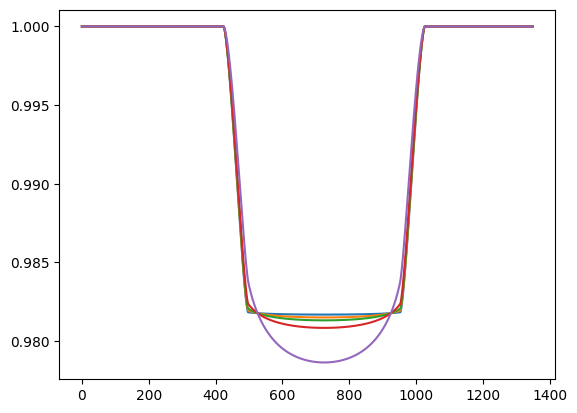

In [8]:
plt.figure()
for rp in [0.01, 0.03, 0.05, 0.1, 0.3]:
    times = d.transits[0].data[0].times.get()
    params = batman.TransitParams()
    params.t0 = 4.03*3600
    params.per = d.P*24*3600
    params.rp = 0.135
    params.a = d.sma
    params.inc = d.i
    params.ecc = d.e
    params.w = 90
    params.limb_dark = 'quadratic'
    params.u = [rp,rp]
    model=batman.TransitModel(params, d.transits[0].data[0].times.get(), exp_time=(times[1]-times[0]), supersample_factor=10000, max_err=1e-3)
    res = model.light_curve(params)
    #res = (res-np.min(res))/(np.max(res)-np.min(res))
    print(np.sum(0*res+1)-np.sum(res))
    plt.plot(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0004078155586683932
        x: [ 4.025e+00  3.273e+00 ... -1.614e-04 -2.372e-05]
      nit: 57
      jac: [ 1.650e-08 -3.065e-07 ... -6.295e-06 -4.413e-07]
 hess_inv: [[ 3.019e+00 -4.030e-01 ...  3.208e-03 -2.426e-02]
            [-4.030e-01  2.248e+01 ...  9.588e-02  2.460e-02]
            ...
            [ 3.208e-03  9.588e-02 ...  2.789e-03  3.268e-04]
            [-2.426e-02  2.460e-02 ...  3.268e-04  1.326e-03]]
     nfev: 1750
     njev: 70
0.0004078155586683932
[ 4.02527398e+00  3.27296341e+00  1.35000000e-01  8.55388396e+00
  8.92642266e+01 -7.77105115e-03  9.00000344e+01  8.56607176e-01
  5.15466358e-01  3.00000000e-01  3.00000000e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.98351491e-01
  0.00000000e+00 -1.73344986e-04 -1.61446668e-04 -2.37206729e-05]
[ 4.03        3.30558875  0.135       8.55078

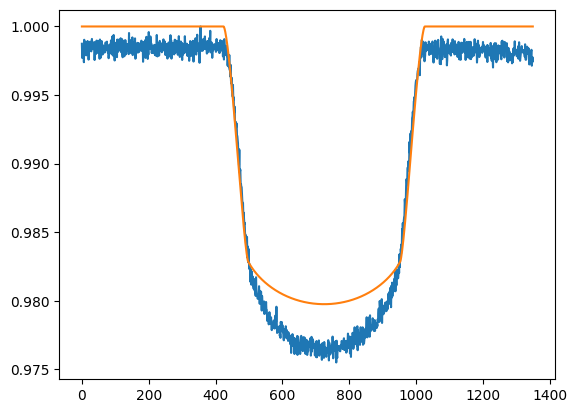

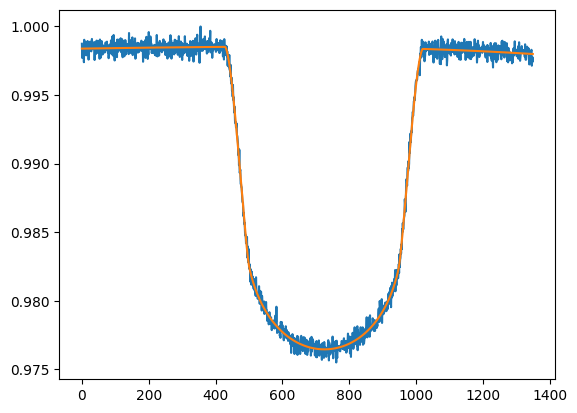

KeyboardInterrupt: 

In [68]:
import scipy
from numpy.polynomial.chebyshev import chebval
which_sensor = 0
times = d.transits[0].data[which_sensor].times.get()
t = times
t_norm = 2*(t - t.min())/(t.max() - t.min()) - 1

target = np.sum(d.transits[0].data[which_sensor].data.get(), axis=1)
target = target/np.max(target)
order=3
λ=0
def f(x, do_plot=False):
    params = batman.TransitParams()
    params.t0 = x[0]*3600
    params.per = x[1]*24*3600
    params.rp = np.sqrt(d.spectrum[0])#x[2]
    params.a = x[3]
    params.inc = x[4]
    params.ecc = x[5]
    params.w = x[6]    
    params.limb_dark = 'uniform'
    params.u = []
    params.limb_dark = 'linear'
    params.u = [x[7]]
    params.limb_dark = 'quadratic' ###
    params.u = [x[7],x[8]]
    #params.limb_dark = 'squareroot'
    #params.u = [x[7],x[8]]
    # params.limb_dark = 'logarithmic'
    # params.u = [x[7],x[8]]
    #params.limb_dark = 'exponential'
    #params.u = [x[7],x[8]]
    #params.limb_dark = 'nonlinear'
    #params.u = [x[7],x[8],x[9],x[10]]
    params.limb_dark = 'power2'
    params.u = [x[7],x[8]]
    #“nonlinear”, “quadratic”, “exponential”, “logarithmic”, “squareroot”, “linear”, “uniform”, “power2”
    model=batman.TransitModel(params, times, exp_time=(times[1]-times[0]), supersample_factor=1, max_err=1)
    res = model.light_curve(params)
    #times_scaled = times/np.max(times)
    #poly_vals = np.poly1d(x[9:9+order+1])(times_scaled)
    #res = res+poly_vals
    xx = copy.deepcopy(x)
    xx[20] = 0
    res = res + chebval(t_norm, xx[20:20+order+1])
    res = res*x[19]
    
    #print(target.shape, res.shape)
    if do_plot:
        plt.figure()
        plt.plot(target)
        plt.plot(res)
        #plt.plot(target-res)
    #print(kgs.rms(target-res))
    return kgs.rms(target-res)
x0 = np.zeros(20+order+1)
x0[0] = 4.03
x0[1] = d.P
x0[2] = 0.135
x0[3] = d.sma
x0[4] = d.i
x0[5] = d.e
x0[6] = 90
x0[7] = 0.3
x0[8] = 0.3
x0[8] = 1.
x0[9] = 0.3
x0[10] = 0.3
x0[19] = 1.0
f(x0)
import scipy
res=scipy.optimize.minimize(f,x0)
print(res)
print(res.fun)
print(res.x)
print(x0)
x = res.x
f(x0, do_plot = True), f(x, do_plot = True)
plt.pause(0.001)

orders = np.arange(10)
r = []
for o in orders:
    order = o
    x0 = np.zeros(20+order+1)
    x0[0] = 4.03
    x0[1] = d.P
    x0[2] = 0.135
    x0[3] = d.sma
    x0[4] = d.i
    x0[5] = d.e
    x0[6] = 90
    x0[7] = 0.3
    x0[8] = 0.3
    x0[9] = 1.0
    res=scipy.optimize.minimize(f,x0)
    r.append(res.fun)
plt.figure()
plt.plot(orders,r)
plt.grid(True)

In [11]:
t_norm.shape

(375,)

In [12]:
target.shape

(375,)

In [35]:
d.spectrum[0], x[2]**2, x

(0.018290660413272,
 0.051278882099770835,
 array([ 4.02714068e+00,  3.32009601e+00,  2.26448409e-01,  8.55496402e+00,
         8.90209477e+01, -7.94558597e-02,  9.00000208e+01,  2.00000000e-01,
         6.00000000e-01,  1.45808146e+00]))

In [37]:
d.spectrum[0], x[2]**2, x

(0.018290660413272,
 0.018854756673787124,
 array([ 4.02527661e+00,  3.30306008e+00,  1.37312624e-01,  8.55258634e+00,
         8.91406634e+01, -1.78231950e-02,  9.00000083e+01,  4.15464014e-01,
         1.87018695e-01,  2.38706828e-02, -1.77300082e-04, -1.60399129e-04,
        -2.30489358e-05]))